### Title: "MAL 03"

| Gruppe 30 |
| --------- |

| Navn                    | Studienummer |
| ----------------------- | ------------ |
| Lasse Borring Petersen  | 202208165    |
| Benjamin Harboe Strunge | 202209864    |
| Esben Inglev            | 202210050    |
| Asbjørn Vad             | 202208512    |


# CNN

## Introduction to CNNs

Convolutional Neural Networks, or CNN's, are a class of neural networks, that work specifically well on tasks such as image recognition, speech recognition, object detection, and other similar tasks. In general, it is good at working with data that comes in a grid-like structure, since it works in 2D instead of 1D.

A CNN consists of several convolutional layers. A Convolutional layer is a layer of neurons, each looking at some smaller part of the data we want to analyze. Eg. if the data is an image, then a neuron might look at a small square of pixels in the corner, and the next neuron will look at the next small square of pixels, and so on. And then in the next convolutional layer, each neuron looks at a small subset of neurons from layer 1. The step size between each field that a neuron is connected to, is called the _stride_, as shown in the image below

<img src="img/CNN_Architecture.png" alt="CNN layer structure" width="500"/>

This convolution can be done using a kernel, which is a matrix of weights, corresponding to how much each field in the lower layer should 'matter', in the final value used in the upper layer on the image above.

A CNN can also have up to several pooling layers in its architecture. These layers are present to reduce the computational complexity of the CNN, as it can get extremely high, even with small sets of data. The idea is to reduce the dimensions of the feature maps, which can be done in some different ways. One of the most common forms is called _Max Pooling_, which is where the max value from a small region is chosen as that regions only data point. If the region is a 2x2 of inputs, then we have effectively reduced our input size by 75%.

#### Sources:

Chapter 14, HOML

Lesson 7 slides


### Model

The following code is the CNN, after all iterations of having tried to maximize a high accuracy.


In [1]:
import keras
from keras import layers
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Generalization
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

model = keras.Sequential([
    layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    
    layers.Dropout(0.25),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=10, activation='softmax'),
])

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["sparse_categorical_accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[callback])

results = model.evaluate(x_test, y_test)

2025-11-13 10:20:12.975405: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 10:20:13.724187: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 10:20:17.111261: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/lassebp7/anaconda3/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-13 10:20:21.089950: E ext

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,130 (1.59 MB)

 Trainable params: 417,018 (1.59 MB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - loss: 0.2317 - sparse_categorical_accuracy: 0.9322 - val_loss: 0.0588 - val_sparse_categorical_accuracy: 0.9824
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.0477 - val_sparse_categorical_accuracy: 0.9869
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.0448 - val_sparse_categorical_accuracy: 0.9883
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - loss: 0.0699 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.0385 - val_sparse_categorical_accuracy: 0.9891
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.0594 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.0346 - val_sparse_categorical_accuracy: 0.9909
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 0.0539 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0391 - val_sparse_categoric

## Questions

### Usage of generalization

In the CNN, generalization is used to divide the dataset into training-, test- and validationdata. The training data is of course used to train the model, but the Keras Sequential class also supports using validation data while its training. It uses this to show the loss and accuracy value while its training, on data that it isnt used for training. We can use this to see how well the model generalizes during training.

If we see that the validation accuracy falls, while the training accuracy increases, we are likely overfitting, and we can catch it earlier than if we did not use a validation set while training.

Then we end it with testing our model on the test data, where we also get a loss and accuracy value. Here we measure how well the model does on completely new data, that wasnt used for either training or validation.

#### Sources

https://keras.io/guides/training_with_built_in_methods/
https://datascience.stackexchange.com/questions/18339/why-use-both-validation-set-and-test-set

### Optimization of results towards high accuracy

The first model that was tested, which's code was largely inspired by the slides, looking like this:

```python
model = keras.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.AveragePooling2D(pool_size=(3,3)),
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.AveragePooling2D(pool_size=(3,3)),
    layers.Flatten(),
    layers.Dense(units=120, activation='relu'),
    layers.Dense(units=84, activation='relu'),
    layers.Dense(units=10, activation='softmax'),
])
```

#### Table of iterations towards a high accuracy

| Change                                                                                                     | Loss  | Accuracy | Comment                                                                                                            |
| ---------------------------------------------------------------------------------------------------------- | ----- | -------- | ------------------------------------------------------------------------------------------------------------------ |
| First model                                                                                                | 0.064 | 0.981    | Benchmark for other results                                                                                        |
| Increase epoch count from 5 to 10                                                                          | 0.061 | 0.983    | Improvement, but also significant increase in runtime.                                                             |
| Change AveragePooling2D layer to MaxPooling2D                                                              | 0.087 | 0.974    | Worse than benchmark result, therefore reverted.                                                                   |
| Change AveragePooling2D to BatchNormalization, increase filter count from 6, 16 to 16, 32.                 | 0.108 | 0.975    | Increased loss and decreased accuracy. Also increased time to train significantly. Reverted.                       |
| Remove middle Dense layer, add two dropout layers.                                                         | 0.052 | 0.984    | Improvement to both loss and accuracy, changes kept.                                                               |
| Trying with epoch=10 and callback function to early exit if no improvement to val_loss over 3 epochs.      | 0.052 | 0.983    | No improvement to be found.                                                                                        |
| Added another convolution2D layer with 10 filters + batch normalization after.                             | 0.040 | 0.988    | Best result so far. Changes kept.                                                                                  |
| Changed filter count from 6, 16, 10 to 8, 16, 24, and added a MaxPool2D layer between conv. layer 2 and 3. | 0.035 | 0.990    | First time accuracy hit 0.99, so definitely the best result we achieved. The loss is also the lowest we have seen. |

### Final CNN Setup

```python
model = keras.Sequential([
    layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.Dropout(0.25),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=10, activation='softmax'),
])
```

### Graph of learning curve

Plotting code written by ChatGPT


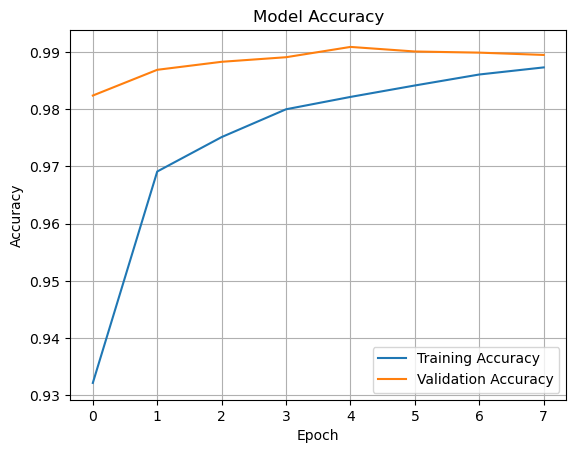

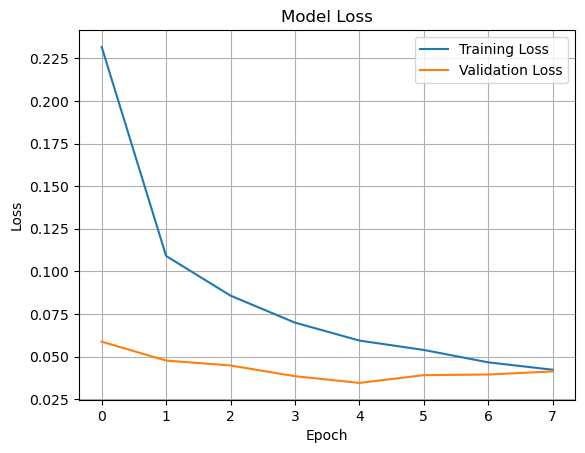

In [2]:
import matplotlib.pyplot as plt

# training & validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

We see that the training and validation accuracy goes up together, and then plateaus around 0.99 for the validation accuracy. This indicated that the model is learning well, and not overfitting.

The validation loss stays hovered around 0.03-0.05, while the training data lowers down to match it. When these two values have been close enough for 3 epochs, the models stops training due to lack of significant improvement.

## Conclusion

This exercise was about trying to create a convolutional neural network, and see how high accuracy we could get on the MNIST dataset. CNN's is a particularly good model to use for this dataset, since it is designed to process grid-structured data, which this dataset is.

Our CNN consists of convolution layers, which slide small filters (kernels) over the data, which detects features in the data. These features are then combined across layers to form higher-level representation of the data. We use several of these layers, but between each of them, we also use pooling layers, to decrease dimensionality and batch normalization, which stabilizes learning. We also use some dropout layers, which randomly deactivates some neurons, that in turn improves generalization.

We tried several different iterations of the model, adding/removing layers, changing hyperparameters, to see how the performance of the model changed. Our goal was to hit an accuracy of >0.99, which we eventually achieved.

In conclusion, using a CNN has given us the best result on the MNIST dataset so far, considerably better than the models we have tried previously on the dataset, like the linear regression.

### Sources

Lesson 7 slides 25 for starting code

For layer inspiration and model buildup
https://keras.io/guides/sequential_model/


# Learning Curves

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/dl_generalization_error.png" alt="WARNING: could not get image from server." style="height:500px">


## Qa - Figure explanation

### Training and generalization error

When training a model, some loss function is often used to measure how good it is at doing its job. This can not just be used to measure how good it is at predicting new data, but also be used during training, to see the error it makes in the training data itself. So during training, before it trains on a certain data point, it checks its prediction for it first, and then measures the error from the actual value. This gives us the training error, which is a measurement of how well our model predict the training data. But just because it is good at that, does not mean it is good on test/actual data.

Generalization is found the same way, but just with the test data instead. This indicates how well our model can predict new data, from training on the training data.

### Underfit/overfit zone

Underfitting is when our model is not good enough to even predict its own training data. This is what happens early in the models training, when it hasn't run for very long. This can also happen if there is not enough data to train on, and the model is unable to become good enough.

Opposite the underfit zone, we have the overfit zone. This is when our model trains 'too well', meaning that it becomes so good at predicting the training data, that it fails on real data. here the training error will be extremely small, but the generalization error is much larger.

### Optimal capacity

Between the underfit/overfit zones, there is an optimal capacity, where the model is good at both predicting new training data, and test data with low errors. This is where you usually want to stop the training, since training it further probably will just push it into the overfitting zone.

### Generalization gap

The generalization gap is the difference between the error the model predicts on new training data vs test data. If there is a large difference, the model is probably overfitting. You want these to be close together, but not exactly the same. If they are, you have probably made a mistake somewhere, like using testdata to train on.

### Axes explained

The y-axis is the calculated error, for both the training and test data. The larger it is, the worse prediction the model is making.

The x-axis is the models capacity, which refers to the models ability to fit a variety of functions and patterns in the data. If the capacity is too small, it will be like trying to do a linear fit on very advanced and varying datasets. This will make it give quite bad predictions on test data.

If the capacity is too large, it will fit too well on training data. We can imagine that the training data is not very varied or advanced, and our model is so advanced and has such a high capacity, that given enough training, it just produces a line between each data point. Then it will be extremely good at predicting the training data, but awful at new test data.


## Qb - Learning curves


LossHistory function was added to the `MyLinReg` class by adding it as another `self.` variable, and initializing it to an empty array. Then everytime we run a fit function, either the BGD or SGD version, we just append the loss from each epoch to the array.

```python
def __init__(self, eta0=0.10, max_iter=1000, tol=1e-5, n_iter_no_change=5, verbose=True):
    self.eta0 = eta0
    self.max_iter = max_iter
    self.tol = tol
    self.n_iter_no_change = n_iter_no_change
    self.verbose = verbose
    self.lossHistory = []

def LossHistory(self):
    return self.lossHistory
```


Converged after 310 iterations.


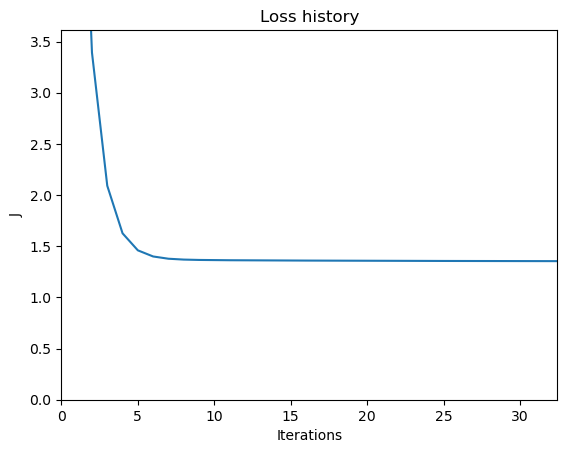

OK


In [3]:
from libitmal import linreg
import numpy as np

r = linreg.MyLinReg()

# Some dummy linear data
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Train your model
r = linreg.MyLinReg(eta0=0.1, max_iter=1000, tol=1e-6, verbose=True)
r.fit(X, y)

h = r.LossHistory()

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(h)

ax.set_title("Loss history")
ax.set_xlabel("Iterations")
ax.set_ylabel("J")

zoom_axis = True
if zoom_axis:
    limits_x = ax.get_xlim()
    limits_y = ax.get_ylim()
    ax.set_ylim([0, limits_y[1]/5]) # zoom on y axis
    ax.set_xlim([0, limits_x[1]/10])
    
plt.show()

print("OK")

# Grid Search


# NanoGPT

## Qa, Qb (and some Qc)

### Introduction

In this exercise, we take a step further into the capabilities of neural networks, with the addition of GPT's. I the exercise, we train a model that can guess the next character to be written, with training from a specific body of text.
The GPT works by looking at a window of inputs, of a certain size, and the produces output is a probability distribution of the next most likely token. In larger LLM's, these tokens are whole or parts of words, but in our case, they are just single characters.

### HCA training

The process of training the HCA data, with the AU GPU cluster, starts by first preparing the data, with `make prepare`.

```makefile
.PHONY:prepare
prepare:
	...
	@ test -f data/$(DATASET)/train.bin  || (echo "RUNNING  data/$(DATASET)/prepare.py.." && cd data/$(DATASET) && $(PYTHON) ./prepare.py)
	@ echo PREPARE: all ok!
```

This last step of the prepare command calls the prepare.py file, which basically just creates mappings of characters into interger id's. This is the tokenizing.

Then comes the training part, with `make train`:

```
.PHONY:train
train:
	@# /home/shared/gpt_node_ok.sh
	$(PYTHON) train.py config/train_$(DATASET).py --max_iters=10 --warmup_iters=1 --eval_iters=1 --eval_interval=1
	@ $(MAKE) -s precondition_predict
	@# more parameters --device=mps --compile=False --eval_iters=20 --log_interval=1 --block_size=64 --batch_size=12 --n_layer=4

```

This command initiates the training, and hold a bunch of training parameters that we know from earlier NN trainings. Here's a brief explanation of some of them:

- `max_iters`: This is the maximum number of training iterations/epochs that the model goes through, before training is stopped.
- `block_size`: This is the size of the window of inputs, also called the context, that the model can have.
- `batch_size`: The batch size is the number of training 'examples' from the data, that the model is trained on each iteration.
- `gradient_accumulation_steps`: This is the number of training iterations the model will go through, while accumulating the gradients. After this amount of iterations, only then are the weights updated. This effectively makes the batch_size bigger, and is nice when memory is limited.

These configurations all play together in the training. Each iteration, the model is given `batch_size` amount of training examples. For each of the examples, the model tries to predict the next character, for each sequence in the `block_size`.

- Based on char 1, it tries to predict char 2
- Based on char 1-2, it tries to preduct char 3
- ...
  So a total of `batch_size` \* `block_size` amount of guesses.

Inside the `config/train_hca.py` file, there's more configuration parameters, some of which specify the transformer setup. Here's a few of them:

- `n_embd`: This is the size of the embeddings of the tokens. An embedding is a vector, which represents the token. So 192, means that each token is represented by a 192 dimension vector.
- `n_layer`: This is the amount of layers in the transformer. Each layer processes the input sequentially, before the final prediction is made from the last layer.
- `n_head`: This is the amount of attention heads. All head are used in each layer, and learns to attend to different patterns. Some heads might attend to the nearby characters, and other might look further back or attend to the whole sentence.
- `dropout`: This is the same as in normal neural networks, where a percentage of the nodes are turned off each iteration, in order to avoid some nodes gaining too much significance.
- `learning_rate`: Learning rate is well known from our other ML studies, and specifies how aggressively we adjust the weights after each iteration, during the backwards pass.

During training, we see continuous loss outputs, and sometimes also validation loss outputs. Lower values mean, that the model gives high probability to the right answer, so that is what we want. Validation loss is calculated at some points during training, and shows how the model performes on unseen data.

### HCA Predicting

When the model is trained, it's time to predict.

```makefile
.PHONY:pred
pred: precondition_predict
	$(PYTHON) sample.py --out_dir=out-$(DATASET) --temperature=0.8 --num_samples=2 --start="Der kom en solda"
```

This make command initiates the prediction. We see the start prompt, "Det kom en solda", and the model will try and predict the next characters.

The temperature is a scaler for the predictions. Lower values will make the model be more likely to choose among it's top most predicted tokens, while larger values will make the model choose more erratic or seemingly random tokens.

Inside the sample.py file, there's also options for setting the amount/length of the output, ie, how many new tokens should be generated.

### Other LLM Lingo

Here's an explanation of some more ML lingo when talking about GPT's and LLM's:

- Design matrix $\mathbf{X}$: This is the input to the model, so basically whatever is in the input.txt file.
- Test data $\mathbf{y}\_\textrm{test}\ $: The test data exists inherintly in the input, because the answer to every series of tokens, is the next token in the input. In this sense, the data is auto-labeled.
- Prompting with LLM's: Prompting is the input we feed to the LLM, or more preciesly, the art of shaping the input in order for the LLM to work as we want it and make it generate the desired output.

### Our own data

For training on our own data, we choose the Pokemon Wikipedia page. https://en.wikipedia.org/wiki/Pok%C3%A9mon

The text is put into a input.txt file, and we followed the setup guide from the `make help` command. During training, we set the model to 1000 iterations, and tested the result. Here's an output from the training:

![Training Start](img/nanotraining1.png)
![Training End](img/nanotraining2.png)

We see here that we end up with a loss of around 1.449.

Here's a prompt with a temperature of 1.0:

![Temp 1.0](img/predict1.png)

Below is the result of a temperature of 0.1:

![Temp 0.1](img/predict2.png)

Even though the output is not coherent with lower temperature, it is easy to see the different in character/token choice the model makes. It's actual words comming out of the second attempt!

### Conclusion

Even though we didn't expect the model to generate any great output, it's still impressive to see how well it performs with such minimal training. It's only trained on a few pages of input, the training lasts under a minute, and still it's able to produce output that is spelling words correctly, and also gives some hints to the theme of the input text.
No wonder that the the whole of Reddit, Wikipedia, Stack overflow, news articles etc, fed into massive datasets thats trained for days or weeks, can produce the LLM's that seem so clever!


#### Sources

- GITMAL L10 NanoGPT folder
- HOML cp. 13 (embeddings)
- HOML cp. 16
- Claude.ai
